In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [86]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [88]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [92]:
# reflect the tables
inspector = inspect(engine)

columns_m = inspector.get_columns('measurement')
for c in columns_m:
    print(c['name'], c["type"])
    
columns_s = inspector.get_columns('station')
for c in columns_s:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [46]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

('2010-01-01',) ('2017-08-23',)


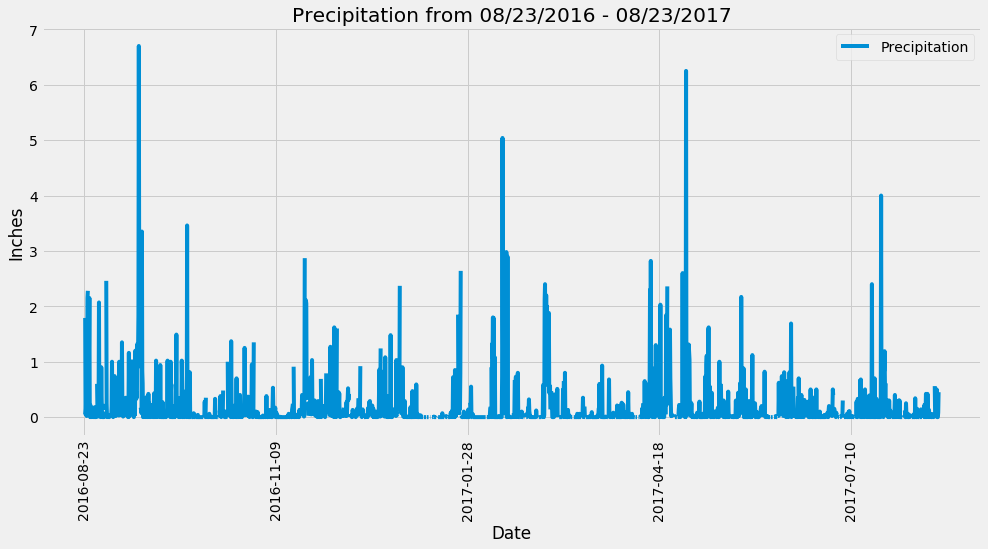

In [85]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [Measurement.date,
       Measurement.prcp]

# Calculate the date 1 year ago from the last data point in the database
earliest = session.query(Measurement.date).order_by(Measurement.date).first()
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print(f'{earliest} {latest}')

import datetime as dt

latest_date = dt.datetime.strptime(latest[0], '%Y-%m-%d')
last_12 = (dt.datetime.strptime(latest[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
last_12

# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(*sel).filter(Measurement.date >= last_12).all()
last_year_data

# Save the query results as a Pandas DataFrame and set the index to the date column
precip = pd.DataFrame(last_year_data, columns=['Date', 'Precipitation'])
precip.set_index('Date', inplace=True)

# Sort the dataframe by date
precip = precip.sort_values(['Date'], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip.plot(rot=90, figsize=(15,7))
plt.title('Precipitation from 08/23/2016 - 08/23/2017')
plt.ylabel('Inches')
plt.show()

In [93]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [100]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(stations)

9


In [130]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [123]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
active_stats = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
print(active_stats)

[(54.0, 85.0, 71.66378066378067)]


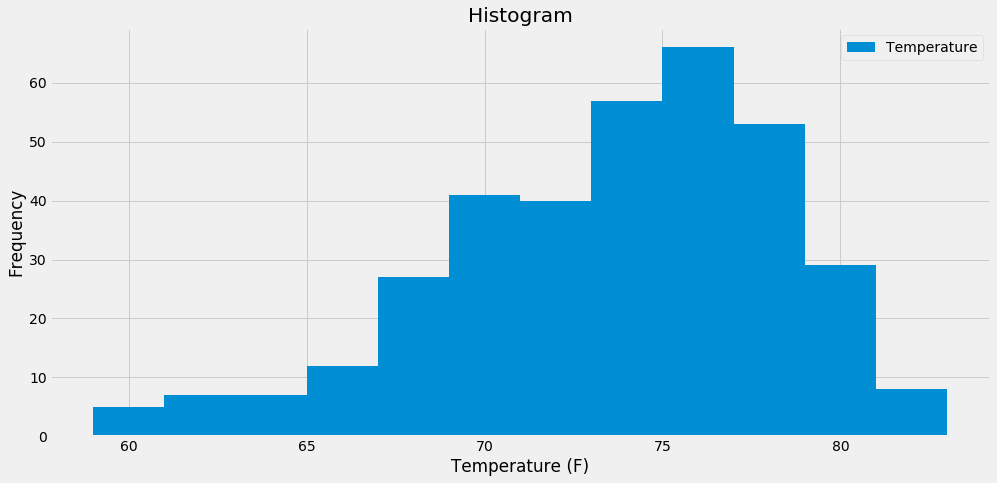

In [138]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station,
       Measurement.date,
       Measurement.tobs]

temp = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= last_12).all()

temp_df = pd.DataFrame(temp, columns=['Station', 'Date', 'Temperature'])
temp_df.plot(kind='hist', bins=12, figsize=(15,7))
plt.title('Histogram')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
